In [4]:
# DB
from questions.models import Solution, Cluster
from evaluation.models import SolutionConcept, Intruder, TopicName, Concept
from django.db.models import Count

# Helpers
import operator
import pandas as pd
from tqdm import tqdm_notebook
from collections import defaultdict

# Math
import numpy as np
import statsmodels

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__lte=last_id)
print("Problems to be used: %d" % problems.count())

solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
# solutions_obj = Solution.objects.all().order_by('id')
print("Solutions to be used: %d" % solutions_obj.count())

docs_id = []
questions = []
solutions = []

# Fill separated structures
for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Problems to be used: 132
Solutions to be used: 54
Got 54 documents


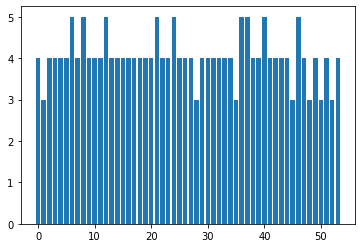

In [7]:
clusters = Cluster.objects.all()
solutions = Solution.objects.filter(id__in=docs_id)
concepts = SolutionConcept.objects.all()
count = concepts.values_list('solution').annotate(count=Count('user', distinct=True))
x, y = zip(*list(count))
# plt.figure(figsize=(10,8))
plt.bar(range(len(x)),y)
plt.show()

### Calculate inter-rater agreement
For each pair of evaluators, calculate how many times they agreed in all 3 concepts, 2 of the 3 concepts, 1 of the 3 concepts or none of the 3 concepts.

In [8]:
%%time

evaluators = concepts.values_list('user').distinct()

category_agreement = defaultdict(int)
agreement = defaultdict(int)
total = 0
total_pairs = 0
agreement_exercises = defaultdict(list)
# agreement_exercises_all = defaultdict(list)

# For each pair of evaluators
for i, eval1 in enumerate(evaluators):
    for j in range(i+1, len(evaluators)):
        eval2 = evaluators[j]
        total_pairs += 1
        
        # Get exercises that they both evaluated
        i_concepts = concepts.filter(user=eval1)
        j_concepts = concepts.filter(user=eval2)
        i_solutions = list(i_concepts.values_list('solution', flat=True).distinct())
        j_solutions = list(j_concepts.values_list('solution', flat=True).distinct())
        same_solutions = set(i_solutions) & set(j_solutions)
        
        # Calculate agreeements and disagreements
        if same_solutions:
            for solution_id in same_solutions:
                i_sol_concepts = list(i_concepts.filter(solution__pk=solution_id).values_list('concept', flat=True))
                j_sol_concepts = list(j_concepts.filter(solution__pk=solution_id).values_list('concept', flat=True))
                agrees = set(i_sol_concepts) & set(j_sol_concepts)
                agreement_exercises[len(agrees)].append(solution_id)
                agreement[len(agrees)] += 1
                total += 1
                for c in agrees:
                    category_agreement[c] += 1
        else:
            continue

CPU times: user 1.87 s, sys: 60.5 ms, total: 1.93 s
Wall time: 2min 10s


In [9]:
from collections import Counter

In [10]:
agreement

defaultdict(int, {1: 130, 2: 157, 3: 29, 0: 23})

In [11]:
total

339

In [12]:
total_pairs

136

In [13]:
def calculate_agreement(clusters):
    cluster_list = []
    for _, row in df_75.iterrows():
        idx = np.argwhere(np.asarray(docs_id) == row['solution'])
        cluster_list.append(clusters[idx[0][0]])
    df = pd.concat([df_75, pd.Series(cluster_list)], axis=1)
    df.columns=['solution', 'concept', 'cluster']
    # Solutions per cluster
    count_df = df.groupby('cluster')['solution'].nunique()
    # Cluster per concept
    max_df = df.groupby(['cluster', 'concept']).count().max(level=0)
    return (max_df.sum()/count_df.sum()).tolist()[0]

In [14]:
solution_100_df = []
solution_75_df = []
# Calculate concepts for each solution
for idx_solution, sol in enumerate(solutions_obj):
        concept_solution = concepts.filter(solution=sol)
        user_count = concept_solution.values_list('solution', 'user__first_name').annotate(count=Count(
            'user', distinct=True)).count()
        count_per_problem = concept_solution.values_list('concept__label', 'solution').annotate(count=Count('concept'))
        allowed_100_concepts = count_per_problem.filter(count__gte=user_count).values_list('concept', flat=True)
        allowed_75_concepts = count_per_problem.filter(count__gte=user_count*0.75).values_list('concept', flat=True)
        for c in allowed_100_concepts:
            solution_100_df.append([sol.pk, c])
        for c in allowed_75_concepts:
            solution_75_df.append([sol.pk, c])
            
df_100 = pd.DataFrame(solution_100_df, columns=['solution', 'concept'])
df_75 = pd.DataFrame(solution_75_df, columns=['solution', 'concept'])

In [15]:
document_clusters = list(solutions_obj.values_list('cluster', flat=True))
agreement_value = calculate_agreement(document_clusters)
print("%.2f" % agreement_value)

0.68


In [16]:
print(len(df_100.groupby('solution').groups))
agree_100 = df_100.groupby('solution').count()

print(len(df_75.groupby('solution').groups))
agree_75 = df_75.groupby('solution').count()

37
53


<QuerySet [{'concept': 12}, {'concept': 7}]>
41.66666666666667
<QuerySet [{'concept': 7}, {'concept': 3}, {'concept': 14}, {'concept': 7}, {'concept': 7}, {'concept': 14}, {'concept': 12}, {'concept': 5}, {'concept': 14}, {'concept': 12}, {'concept': 1}, {'concept': 14}, {'concept': 12}, {'concept': 14}, {'concept': 11}, {'concept': 11}]>
34.78260869565217
<QuerySet [{'concept': 14}, {'concept': 12}, {'concept': 11}, {'concept': 11}, {'concept': 12}, {'concept': 12}, {'concept': 7}, {'concept': 11}, {'concept': 14}, {'concept': 11}, {'concept': 11}, {'concept': 13}, {'concept': 11}, {'concept': 11}]>
29.508196721311474
<QuerySet [{'concept': 12}, {'concept': 11}, {'concept': 8}, {'concept': 12}, {'concept': 13}, {'concept': 12}]>
44.44444444444444
<QuerySet [{'concept': 7}, {'concept': 12}, {'concept': 12}, {'concept': 12}, {'concept': 13}, {'concept': 12}]>
18.367346938775512


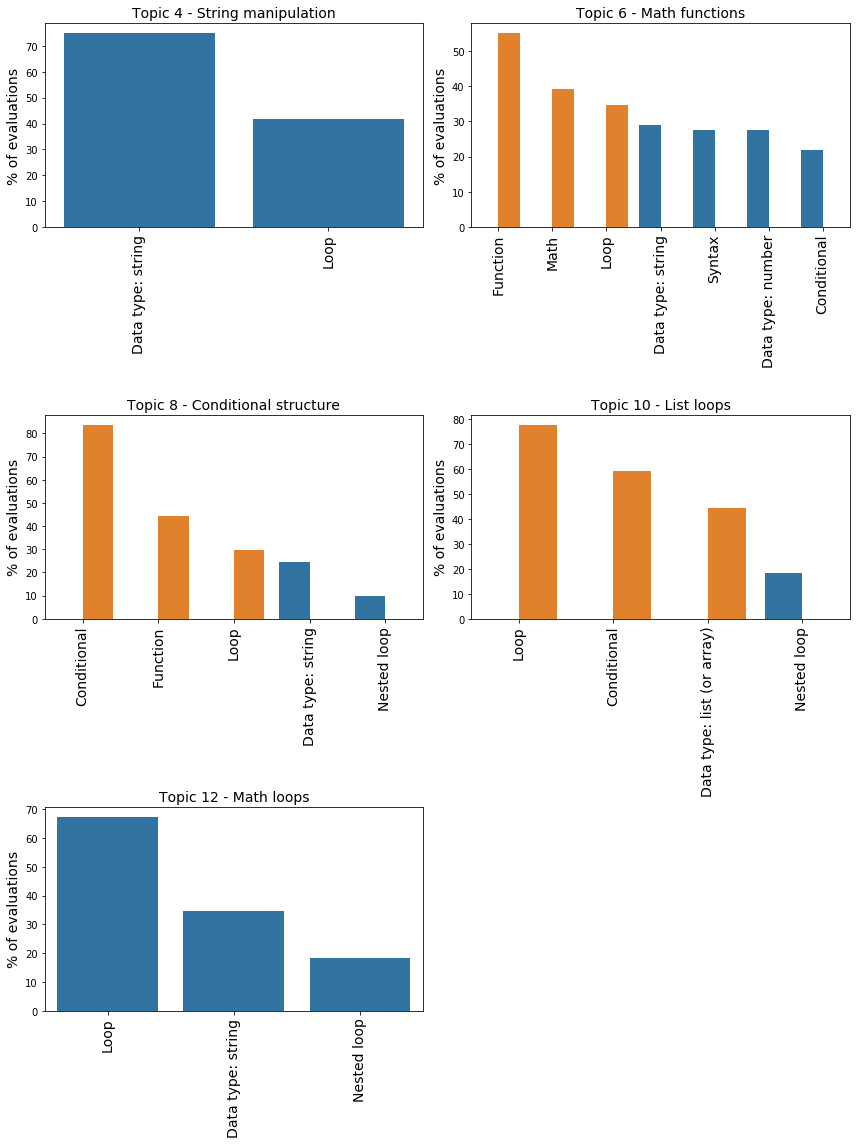

In [17]:
concept_solution = []
fig = plt.figure(figsize=(12,16))
for idx_cluster, cluster in enumerate(clusters):
    # Get solutions belonging to cluster
    solution_cluster = solutions.filter(cluster=cluster)
    
    # Get voted concepts
    concept_solution = concepts.filter(solution__in=solution_cluster)
    
    # Calculate max of points a concept can have
    user_count = concept_solution.values_list('solution').annotate(count=Count('user', distinct=True))
    max_points = sum(list(zip(*user_count))[1])
    
    # Just consider concepts that had more than one vote in the problem
    count_per_problem = concept_solution.values_list('concept__label', 'solution').annotate(count=Count('concept'))
    allowed_concepts = count_per_problem.filter(count__gte=4).values('concept')
    print(allowed_concepts)
    
    # Count quantity of votes for each concept 
    count = list(concept_solution.filter(concept__in=allowed_concepts
                                        ).values_list('concept__label').annotate(count=Count('concept')))
    count.sort(key=operator.itemgetter(1), reverse=True)
    
    # Transform to percentage and set threshold limit for top 3 results
    df = pd.DataFrame(count, columns=["concept", "count"])
    df['count'] = df.apply(lambda x: x["count"]/max_points*100, axis=1)
    threshold = df.nlargest(3, 'count').tail(1)['count'].tolist()[0]
    print(threshold)
    df['top 3'] = df.apply(lambda x: True if x["count"] >= threshold else False, axis=1)
    
    # Plot
    subplot = 321 + idx_cluster
    fig.add_subplot(subplot)
    plt.title("Topic %d - %s" % (cluster.id, cluster.label), fontsize=14)
    g = sns.barplot(x='concept', y='count', hue='top 3', data=df)
    g.legend_.remove()
    plt.xticks(fontsize=14, rotation=90)
    plt.xlabel("")
    plt.ylabel("% of evaluations", fontsize=14)

plt.tight_layout()
plt.savefig("images/evaluation.png")
plt.savefig("images/evaluation.eps", format="eps")
plt.show()

In [18]:
# Scores
scores = defaultdict(dict)
clusters = list(Cluster.objects.all().values_list('id', flat=True).distinct().order_by('id'))
confusion = np.zeros((len(clusters), len(clusters)))
total = np.zeros((len(clusters), len(clusters)))

# Get all user and cluster combinations
user_cluster = Intruder.objects.all().values_list('user', 'cluster').distinct()

for uc in user_cluster:
    # Get solution classified as intruder by the user for given cluster
    # There should be only one per group, so using get shouldn't raise any errors
    user_intruder = Intruder.objects.get(user=uc[0], cluster=uc[1], intruder=True)
    scores[user_intruder.cluster.label]["label"] = user_intruder.cluster.label
    
    # Get correct answers
    actual_intruder = Intruder.objects.exclude(solution__cluster__id=user_intruder.cluster.id).get(
        user=uc[0], cluster=uc[1])
    expected = clusters.index(actual_intruder.cluster.id)
    predicted = clusters.index(actual_intruder.solution.cluster.id)
    
    # If it's actually an intruder
    if user_intruder.cluster != user_intruder.solution.cluster:
        try:
            scores[user_intruder.cluster.label]["correct"] += 1
        except KeyError:
            scores[user_intruder.cluster.label]["correct"] = 1
            
        # If it is correct, one more point is given to the cluster
        confusion[expected, expected] += 1
    else:
        try:
            scores[user_intruder.cluster.label]["wrong"] += 1
        except KeyError:
            scores[user_intruder.cluster.label]["wrong"] = 1
            
        # Create confusion matrix (rows are correct, columns are inferred)
        confusion[expected, predicted] += 1
    
    # Count to compare number of 
#     total[expected, predicted] += 1

In [19]:
confusion

array([[ 7.,  2.,  1.,  2.,  2.],
       [ 0.,  3.,  3.,  1.,  7.],
       [ 0.,  1., 11.,  0.,  2.],
       [ 2.,  2.,  1.,  7.,  2.],
       [ 0.,  1.,  0.,  4.,  9.]])

In [20]:
confusion_percent = np.true_divide(confusion, confusion.sum(axis=1))
confusion_percent

array([[0.5       , 0.14285714, 0.07142857, 0.14285714, 0.14285714],
       [0.        , 0.21428571, 0.21428571, 0.07142857, 0.5       ],
       [0.        , 0.07142857, 0.78571429, 0.        , 0.14285714],
       [0.14285714, 0.14285714, 0.07142857, 0.5       , 0.14285714],
       [0.        , 0.07142857, 0.        , 0.28571429, 0.64285714]])

In [21]:
clusters = list(Cluster.objects.all().values_list('label', flat=True).distinct().order_by('id'))
#clusters = list(Cluster.objects.all().values_list('id', flat=True).distinct().order_by('id'))
confusion_df = pd.DataFrame(confusion_percent, columns=clusters, index=clusters)
#confusion_df = pd.DataFrame(confusion, columns=clusters, index=clusters)
confusion_df

,String manipulation,Math functions,Conditional structure,List loops,Math loops
String manipulation,0.500000,0.142857,0.071429,0.142857,0.142857
Math functions,0.000000,0.214286,0.214286,0.071429,0.500000
Conditional structure,0.000000,0.071429,0.785714,0.000000,0.142857
List loops,0.142857,0.142857,0.071429,0.500000,0.142857
Math loops,0.000000,0.071429,0.000000,0.285714,0.642857


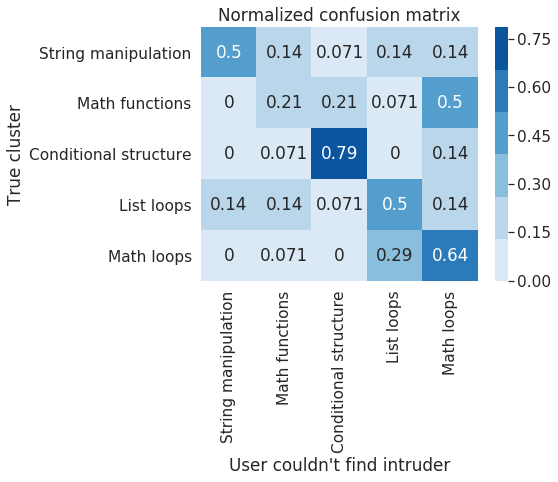

In [22]:
#cmap = sns.diverging_palette(10, 138, l=70, n=20)
cmap = (sns.color_palette("Blues"))
plt.figure(figsize=(8,7))
sns.set(font_scale=1.4)
sns.heatmap(confusion_df, annot=True, cmap=cmap)
#sns.heatmap(confusion_df, annot=True)
plt.title("Normalized confusion matrix")
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.xlabel("User couldn't find intruder")#, fontsize=14)
plt.ylabel("True cluster")#, fontsize=14)
plt.ylim(5, 0)
plt.tight_layout()
plt.savefig("data/tese/confusion_matrix.png")
plt.savefig("data/tese/confusion_matrix.eps", format="eps")
plt.show()

In [23]:
df = pd.DataFrame.from_dict(scores, orient='index')
df = df.sort_values('correct', ascending=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


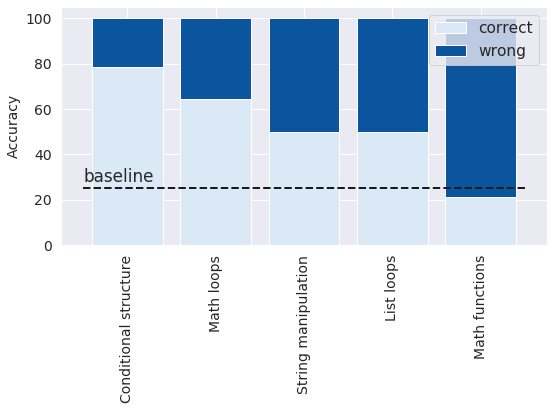

In [24]:
# From raw value to percentage
totals = [i+j for i,j in zip(df['correct'], df['wrong'])]
correctBars = [i / j * 100 for i,j in zip(df['correct'], totals)]
wrongBars = [i / j * 100 for i,j in zip(df['wrong'], totals)]

plt.figure(figsize=(8,6))
# Create correct Bars
plt.bar(df.index, correctBars, color=cmap[0], label="correct")
# Create wrong Bars
plt.bar(df.index, wrongBars, color=cmap[-1], bottom=correctBars, label="wrong")
# # Create blue Bars

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend()

# Plot baseline
plt.plot([-0.5, 4.5], [25, 25], 'k--', lw=2)
plt.text(-0.5, 28, "baseline")

# Show graphic
plt.tight_layout()
plt.savefig("data/tese/accuracy.png")
plt.savefig("data/tese/accuracy.eps", format="eps")
plt.show()

In [30]:
from collections import Counter
from wordcloud import WordCloud

manipulação de strings
manipulação de listas
funções de manipulação de strings
list manipulation
function, loop, syntax
Concatenação de Strings
Manipulação de strings
Split e Separadores
Dict
processamento de strings
sanitize

funções
?
funções
functions
Funções Simples
function, math, loop
Tipos Numéricos
Operações aritméticas e tipos numéricos
Retorno de funções
Math and Syntax
tipos de dados e operações matemáticas
numbers

estrutura condicional
pesquisa e ordenação
condicional
choice
function, conditional, logic
Estrutura condicional (IF...ELSE)
Estrutura condicional
Conditional
Nested Loop
estrutura condicional, iteração em strings
numbers

dicionários, listas
manipulação de dados compostos
listas e dicionários
checking lists
function, loop, conditional
Loops com FOR
Loop for e condicional
Laço de Repetição For
Loop
dicionários, loops, iteração em listas
reducers

loop aninhado, string, int
dados numéricos e suas operações
listas e dicionários
math problems
function, loop, math
Lo

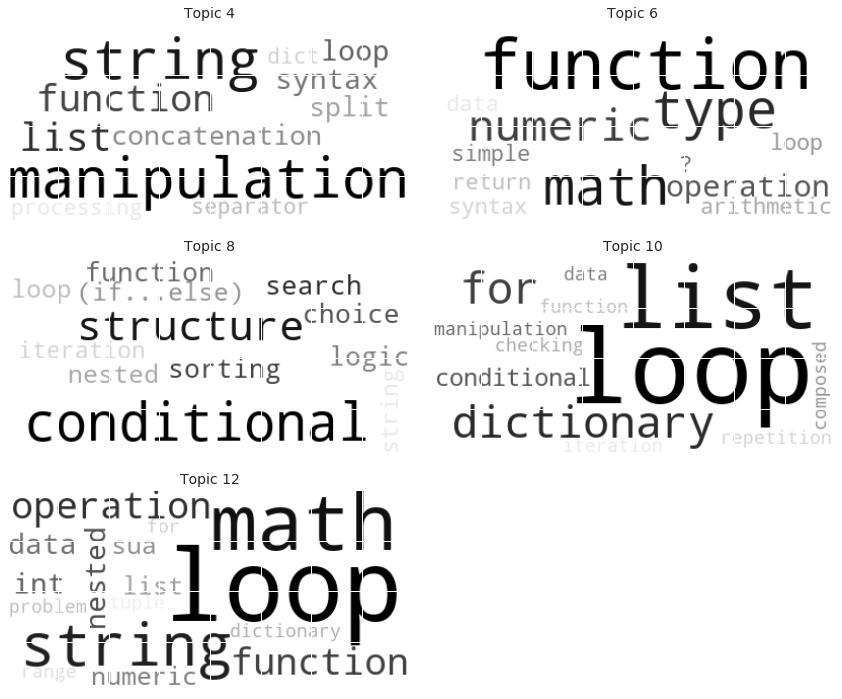

In [44]:
stopwords = ["de", "e", "em", "and", "sua", "com"]
en_pt = {
    "function": "funçõe",
    "math": "matemática",
    "list": "lista",
    "conditional": "condicional"
}
pt_en = {
    "funçõe": "function",
    "função": "function",
    "matemática": "math",
    "tipo": "type",
    "numérico": "numeric",
    "operaçõe": "operation",
    "aritmética": "arithmetic",
    "retorno": "return",
    "dado": "data",
    "manipulação": "manipulation",
    "lista": "list",
    "concatenação": "concatenation",
    "separadore": "separator",
    "processamento": "processing",
    "condicional": "conditional",
    "estrutura": "structure",
    "pesquisa": "search",
    "ordenação": "sorting",
    "iteração": "iteration",
    "aninhado": "nested",
    "dicionário": "dictionary",
    "composto": "composed",
    "laço": "loop",
    "repetição": "repetition"
}

cluster = TopicName.objects.all().values_list('cluster').distinct().order_by('cluster__id')
plt.figure(figsize=(12,10))
word_count = []
total = []
for idx_cluster,c in enumerate(cluster):
    names = TopicName.objects.filter(cluster=c)
    tokens = []
    for n in names:
        print(n.label)
        tmp_tokens = n.label.lower().replace(",","").split(" ")
        tmp_tokens = [t.strip() for t in tmp_tokens if t not in stopwords]
        tmp_tokens = [t.rstrip('s') for t in tmp_tokens if t not in stopwords]
        tmp_tokens = [pt_en[t] if t in pt_en.keys() else t for t in tmp_tokens]
        tokens += tmp_tokens
    print()
    c_tokens = Counter(tokens)
    sorted(c_tokens.items(), key = lambda x:x[1] , reverse=True)
    cs = list(zip(*sorted(c_tokens.items(), key = lambda x:x[1] , reverse=True)))[0]
    word_count.append(c_tokens)
    total.append(names.count())
    wc = WordCloud(background_color="white", max_words=1000, color_func=colormap_color_func("gray", frequencies=cs))
    # generate word cloud
    wc.generate_from_frequencies(c_tokens)
    # Plot
    ax= plt.subplot(3, 2 ,idx_cluster+1)
    ax.set_title("Topic %d" % c[0], fontsize=14)
    im = ax.imshow(wc, interpolation="bilinear")
    plt.tick_params(
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False)
#     ax.axis("off")
plt.tight_layout()
plt.savefig("images/topic_names.png")
plt.savefig("images/topic_names.eps", format="eps")
plt.show()

In [32]:
class colormap_color_func(object):
    """Color func created from matplotlib colormap.
    Parameters
    ----------
    colormap : string or matplotlib colormap
        Colormap to sample from
    Example
    -------
    >>> WordCloud(color_func=colormap_color_func("magma"))
    """
    def __init__(self, colormap, frequencies):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap, len(frequencies))
        self.frequencies = frequencies

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        
        idx = list(self.frequencies).index(word)
        r, g, b, _ = np.maximum(0, 255 * np.array(self.colormap(idx)))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

In [40]:
total

[11, 12, 11, 11, 11]

In [39]:
word_count

[Counter({'manipulation': 5,
          'string': 5,
          'list': 2,
          'function': 2,
          'loop': 1,
          'syntax': 1,
          'concatenation': 1,
          'split': 1,
          'separator': 1,
          'dict': 1,
          'processing': 1,
          'sanitize': 1}),
 Counter({'function': 6,
          '?': 1,
          'simple': 1,
          'math': 3,
          'loop': 1,
          'type': 3,
          'numeric': 2,
          'operation': 2,
          'arithmetic': 1,
          'return': 1,
          'syntax': 1,
          'data': 1,
          'number': 1}),
 Counter({'structure': 4,
          'conditional': 7,
          'search': 1,
          'sorting': 1,
          'choice': 1,
          'function': 1,
          'logic': 1,
          '(if...else)': 1,
          'nested': 1,
          'loop': 1,
          'iteration': 1,
          'string': 1,
          'number': 1}),
 Counter({'dictionary': 3,
          'list': 4,
          'manipulation': 1,
          'da